In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('data/cleaned_data.csv')
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
x = data.drop(['diagnosis'], axis=1)
y = data['diagnosis']

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [5]:
from sklearn.preprocessing import MinMaxScaler
x_columns = x_train.columns
min_max_scaler = MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(x_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=x_columns)

x_test_scaled = min_max_scaler.transform(x_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=x_columns)

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
rf = RandomForestClassifier(random_state=1)
rf.fit(x_train_scaled, y_train)

features = x_train_scaled.columns
importance = rf.feature_importances_

print(pd.DataFrame({"Features": features,
			  "Importance": importance}).sort_values('Importance', ascending=False).to_string())

                   Features  Importance
22          perimeter_worst    0.130773
27     concave points_worst    0.130307
23               area_worst    0.117678
7       concave points_mean    0.091731
20             radius_worst    0.084314
0               radius_mean    0.068120
2            perimeter_mean    0.066514
6            concavity_mean    0.058548
3                 area_mean    0.045622
26          concavity_worst    0.030877
13                  area_se    0.028895
10                radius_se    0.022150
1              texture_mean    0.018957
21            texture_worst    0.017575
25        compactness_worst    0.010925
28           symmetry_worst    0.009239
24         smoothness_worst    0.009142
12             perimeter_se    0.007799
29  fractal_dimension_worst    0.006728
4           smoothness_mean    0.005597
19     fractal_dimension_se    0.005263
5          compactness_mean    0.005008
17        concave points_se    0.004986
18              symmetry_se    0.004590


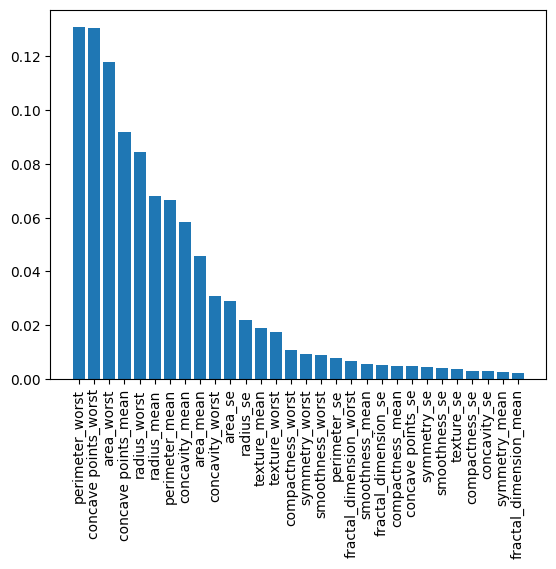

In [8]:
import matplotlib.pyplot as plt
feature_importance = pd.DataFrame({"Features": features, "Importance": importance}).sort_values('Importance', ascending=False)
plt.bar(feature_importance['Features'], feature_importance['Importance'])
plt.xticks(rotation=90)
plt.show()

In [9]:
important_features = feature_importance['Features'].head(5).tolist()
important_features

['perimeter_worst',
 'concave points_worst',
 'area_worst',
 'concave points_mean',
 'radius_worst']

In [10]:
x_train_scaled = x_train_scaled[important_features]
x_test_scaled = x_test_scaled[important_features]

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from time import perf_counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib

In [12]:
parameters = {'n_estimators': [5, 10, 20, 50, 100], 'max_depth': [5, 10, 20, 30, None]}

rf = RandomForestClassifier(random_state=1)
rf_model = GridSearchCV(rf, parameters)
rf_model.fit(x_train_scaled, y_train)

pd.DataFrame(rf_model.cv_results_).to_csv('model_performance/reduced_features_rf_gridsearch_cv.csv', index=False)

rf_model.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [13]:
rf = RandomForestClassifier(n_estimators=rf_model.best_params_["n_estimators"],
							max_depth=rf_model.best_params_["max_depth"])

start_train = perf_counter()
rf.fit(x_train_scaled, y_train)
finish_train = perf_counter()

start_test = perf_counter()
y_pred = rf.predict(x_test_scaled)
finish_test = perf_counter()

accuracy = "%.3f" % metrics.accuracy_score(y_test, y_pred)
precision = "%.3f" % metrics.precision_score(y_test, y_pred, pos_label='M')
recall = "%.3f" % metrics.recall_score(y_test, y_pred, pos_label='M')

train_time = finish_train - start_train
test_time = finish_test - start_test
print(f'Train Time: {train_time} / Predict Time: {test_time}')

print(f'Estimators: {rf_model.best_params_["n_estimators"]} / Depth: {rf_model.best_params_["max_depth"]} --- Accuracy: {accuracy} / Precision: {precision} / Recall: {recall}')


Train Time: 0.14243740000529215 / Predict Time: 0.00434699998004362
Estimators: 100 / Depth: 5 --- Accuracy: 0.956 / Precision: 1.000 / Recall: 0.881


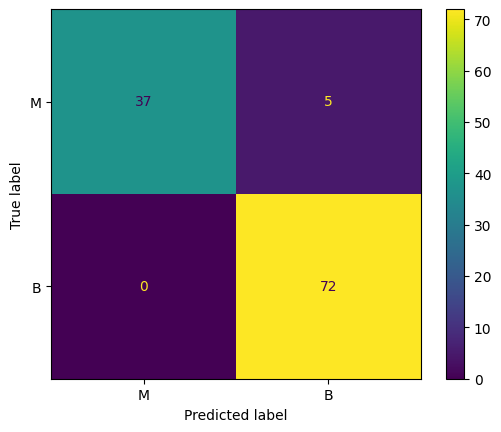

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=['M', 'B'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['M', 'B'])
disp.plot()
# plt.show()
plt.savefig('visuals/confusion_matrix/reduced_features_rf_confusion_matrix.png')

In [15]:
joblib.dump(rf, 'saved_objects/reduced_features_rf.pkl')

['saved_objects/reduced_features_rf.pkl']

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
parameters = {'penalty': [None, 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

lr = LogisticRegression()
lr_model = GridSearchCV(lr, parameters)
lr_model.fit(x_train_scaled, y_train)

pd.DataFrame(lr_model.cv_results_).to_csv('model_performance/reduced_features_lr_gridsearch_cv.csv', index=False)

lr_model.best_params_

C:\Users\rueip\PycharmProjects\Breast-Cancer-Wisconsin-Diagnosis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\rueip\PycharmProjects\Breast-Cancer-Wisconsin-Diagnosis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\rueip\PycharmProjects\Breast-Cancer-Wisconsin-Diagnosis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\rueip\PycharmProjects\Breast-Cancer-Wisconsin-Diagnosis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\rueip\PycharmProjects\Breast-Cancer-Wisconsin-Diagnosis\venv\Lib\site-packages\sklearn\linear_model\_logist

{'C': 0.0001, 'penalty': None}

In [18]:
lr = LogisticRegression(C=lr_model.best_params_["C"],
						penalty=lr_model.best_params_["penalty"])

start_train = perf_counter()
lr.fit(x_train_scaled, y_train)
finish_train = perf_counter()

start_test = perf_counter()
y_pred = lr.predict(x_test_scaled)
finish_test = perf_counter()

accuracy = "%.3f" % metrics.accuracy_score(y_test, y_pred)
precision = "%.3f" % metrics.precision_score(y_test, y_pred, pos_label='M')
recall = "%.3f" % metrics.recall_score(y_test, y_pred, pos_label='M')

train_time = finish_train - start_train
test_time = finish_test - start_test
print(f'Train Time: {train_time} / Predict Time: {test_time}')

print(f'C: {lr_model.best_params_["C"]} / Penalty: {lr_model.best_params_["penalty"]} --- Accuracy: {accuracy} / Precision: {precision} / Recall: {recall}')


Train Time: 0.00963340001180768 / Predict Time: 0.0008977999677881598
C: 0.0001 / Penalty: None --- Accuracy: 0.956 / Precision: 1.000 / Recall: 0.881


C:\Users\rueip\PycharmProjects\Breast-Cancer-Wisconsin-Diagnosis\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


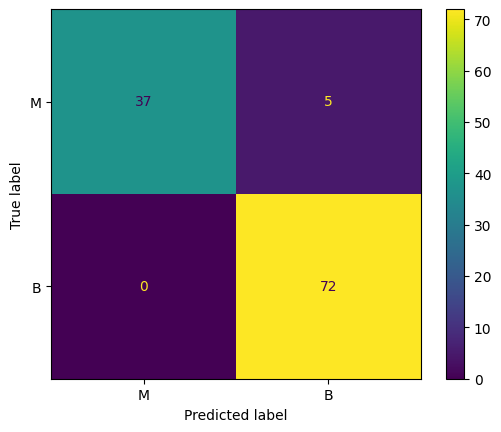

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=['M', 'B'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['M', 'B'])
disp.plot()
# plt.show()
plt.savefig('visuals/confusion_matrix/reduced_features_lr_confusion_matrix.png')

In [20]:
joblib.dump(lr, 'saved_objects/reduced_features_lr.pkl')

['saved_objects/reduced_features_lr.pkl']

In [21]:
from sklearn.svm import SVC

In [22]:
parameters = {'C': [0.1, 1, 10], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'degree': [2, 3, 4, 5, 6]}

svm = SVC()
svm_model = GridSearchCV(svm, parameters)
svm_model.fit(x_train_scaled, y_train)

pd.DataFrame(svm_model.cv_results_).to_csv('model_performance/reduced_features_svm_gridsearch_cv.csv', index=False)

svm_model.best_params_

{'C': 0.1, 'degree': 2, 'kernel': 'rbf'}

In [23]:
svm = SVC(C=svm_model.best_params_["C"],
		  degree=svm_model.best_params_["degree"],
		  kernel=svm_model.best_params_["kernel"])

start_train = perf_counter()
svm.fit(x_train_scaled.values, y_train)
finish_train = perf_counter()

start_test = perf_counter()
y_pred = svm.predict(x_test_scaled.values)
finish_test = perf_counter()


accuracy = "%.3f" % metrics.accuracy_score(y_test, y_pred)
precision = "%.3f" % metrics.precision_score(y_test, y_pred, pos_label='M')
recall = "%.3f" % metrics.recall_score(y_test, y_pred, pos_label='M')


train_time = finish_train - start_train
test_time = finish_test - start_test
print(f'Train Time: {train_time} / Predict Time: {test_time}')

print(f'C: {svm_model.best_params_["C"]} / Degree: {svm_model.best_params_["degree"]} / Kernel: {svm_model.best_params_["kernel"]} --- Accuracy: {accuracy} / Precision: {precision} / Recall: {recall}')


Train Time: 0.004874900041613728 / Predict Time: 0.0026488000294193625
C: 0.1 / Degree: 2 / Kernel: rbf --- Accuracy: 0.956 / Precision: 1.000 / Recall: 0.881


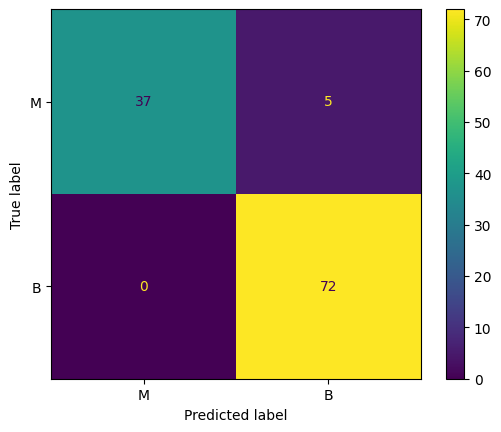

In [24]:
cm = confusion_matrix(y_test, y_pred, labels=['M', 'B'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['M', 'B'])
disp.plot()
# plt.show()
plt.savefig('visuals/confusion_matrix/reduced_features_svm_confusion_matrix.png')

In [25]:
joblib.dump(svm, 'saved_objects/reduced_features_svc.pkl')


['saved_objects/reduced_features_svc.pkl']

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
parameters = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'weights': ['uniform', 'distance']}

knn = KNeighborsClassifier()
knn_model = GridSearchCV(knn, parameters)
knn_model.fit(x_train_scaled.values, y_train)

pd.DataFrame(knn_model.cv_results_).to_csv('model_performance/reduced_features_knn_gridsearch_cv.csv', index=False)

knn_model.best_params_

{'n_neighbors': 5, 'weights': 'uniform'}

In [28]:
knn = KNeighborsClassifier(n_neighbors=knn_model.best_params_["n_neighbors"],
						   weights=knn_model.best_params_["weights"])

start_train = perf_counter()
knn.fit(x_train_scaled, y_train)
finish_train = perf_counter()

start_test = perf_counter()
y_pred = knn.predict(x_test_scaled)
finish_test = perf_counter()

accuracy = "%.3f" % metrics.accuracy_score(y_test, y_pred)
precision = "%.3f" % metrics.precision_score(y_test, y_pred, pos_label='M')
recall = "%.3f" % metrics.recall_score(y_test, y_pred, pos_label='M')

train_time = finish_train - start_train
test_time = finish_test - start_test
print(f'Train Time: {train_time} / Predict Time: {test_time}')

print(f'Neighbors: {knn_model.best_params_["n_neighbors"]} / Weights: {knn_model.best_params_["weights"]} --- Accuracy: {accuracy} / Precision: {precision} / Recall: {recall}')


Train Time: 0.0032614999799989164 / Predict Time: 0.007123899995349348
Neighbors: 5 / Weights: uniform --- Accuracy: 0.947 / Precision: 0.974 / Recall: 0.881


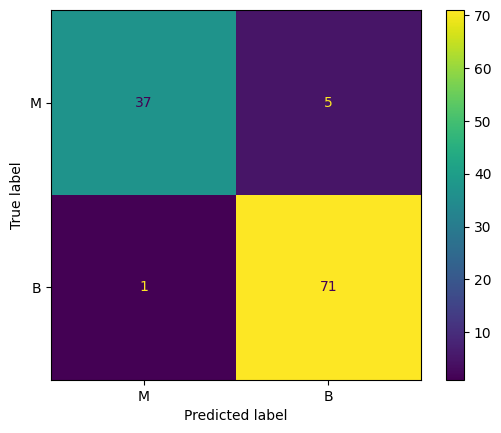

In [29]:
cm = confusion_matrix(y_test, y_pred, labels=['M', 'B'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['M', 'B'])
disp.plot()
# plt.show()
plt.savefig('visuals/confusion_matrix/reduced_features_knn_confusion_matrix.png')

In [30]:
joblib.dump(knn, 'saved_objects/reduced_features_knn.pkl')


['saved_objects/reduced_features_knn.pkl']

In [31]:
from sklearn.neural_network import MLPClassifier

In [32]:
parameters = {'hidden_layer_sizes': [10, 20, 50, 100], 'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam']}

mlp = MLPClassifier()
mlp_model = GridSearchCV(mlp, parameters)
mlp_model.fit(x_train_scaled, y_train)

pd.DataFrame(mlp_model.cv_results_).to_csv('model_performance/reduced_features_mlp_gridsearch_cv.csv', index=False)

mlp_model.best_params_

C:\Users\rueip\PycharmProjects\Breast-Cancer-Wisconsin-Diagnosis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rueip\PycharmProjects\Breast-Cancer-Wisconsin-Diagnosis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rueip\PycharmProjects\Breast-Cancer-Wisconsin-Diagnosis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rueip\PycharmProjects\Breast-Cancer-Wisconsin-Diagnosis\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochas

{'activation': 'identity', 'hidden_layer_sizes': 10, 'solver': 'lbfgs'}

In [33]:
mlp = MLPClassifier(activation=mlp_model.best_params_["activation"],
					hidden_layer_sizes=mlp_model.best_params_["hidden_layer_sizes"],
					solver=mlp_model.best_params_["solver"])

start_train = perf_counter()
mlp.fit(x_train_scaled, y_train)
finish_train = perf_counter()

start_test = perf_counter()
y_pred = mlp.predict(x_test_scaled)
finish_test = perf_counter()

accuracy = "%.3f" % metrics.accuracy_score(y_test, y_pred)
precision = "%.3f" % metrics.precision_score(y_test, y_pred, pos_label='M')
recall = "%.3f" % metrics.recall_score(y_test, y_pred, pos_label='M')

train_time = finish_train - start_train
test_time = finish_test - start_test
print(f'Train Time: {train_time} / Predict Time: {test_time}')

print(f'Hidden Layer Size: {mlp_model.best_params_["hidden_layer_sizes"]} / Activation: {mlp_model.best_params_["activation"]} / Solver: {mlp_model.best_params_["solver"]} --- Accuracy: {accuracy} / Precision: {precision} / Recall: {recall}')


Train Time: 0.013952700013760477 / Predict Time: 0.0009351000189781189
Hidden Layer Size: 10 / Activation: identity / Solver: lbfgs --- Accuracy: 0.956 / Precision: 1.000 / Recall: 0.881


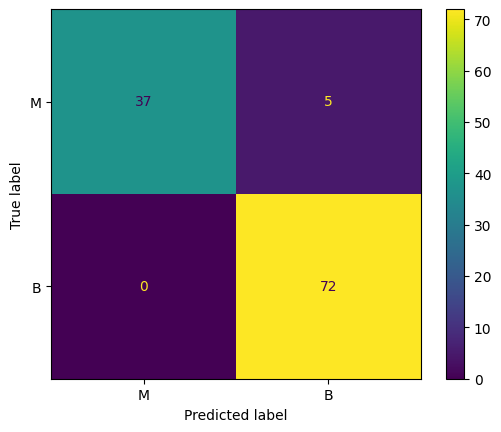

In [34]:
cm = confusion_matrix(y_test, y_pred, labels=['M', 'B'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['M', 'B'])
disp.plot()
# plt.show()
plt.savefig('visuals/confusion_matrix/reduced_features_mlp_confusion_matrix.png')

In [35]:
joblib.dump(mlp, 'saved_objects/reduced_features_mlp.pkl')


['saved_objects/reduced_features_mlp.pkl']

Train Time: 0.0027779999654740095 / Predict Time: 0.00136160000693053
Accuracy: 0.956 / Precision: 1.000 / Recall: 0.881


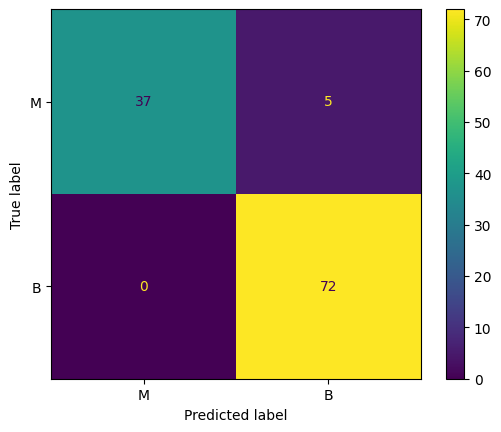

In [36]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()

start_train = perf_counter()
nb.fit(x_train_scaled, y_train)
finish_train = perf_counter()

start_test = perf_counter()
y_pred = nb.predict(x_test_scaled)
finish_test = perf_counter()

train_time = finish_train - start_train
test_time = finish_test - start_test

accuracy = "%.3f" % metrics.accuracy_score(y_test, y_pred)
precision = "%.3f" % metrics.precision_score(y_test, y_pred, pos_label='M')
recall = "%.3f" % metrics.recall_score(y_test, y_pred, pos_label='M')

print(f'Train Time: {train_time} / Predict Time: {test_time}')
print(f'Accuracy: {accuracy} / Precision: {precision} / Recall: {recall}')
joblib.dump(nb, 'saved_objects/reduced_features_nb.pkl')
cm = confusion_matrix(y_test, y_pred, labels=['M', 'B'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
							  display_labels=['M', 'B'])
disp.plot()
# plt.show()
plt.savefig('visuals/confusion_matrix/reduced_features_gaussian_nb_confusion_matrix.png')

Train Time: 0.0023705000057816505 / Predict Time: 0.001132700010202825
Accuracy: 0.904 / Precision: 0.943 / Recall: 0.786


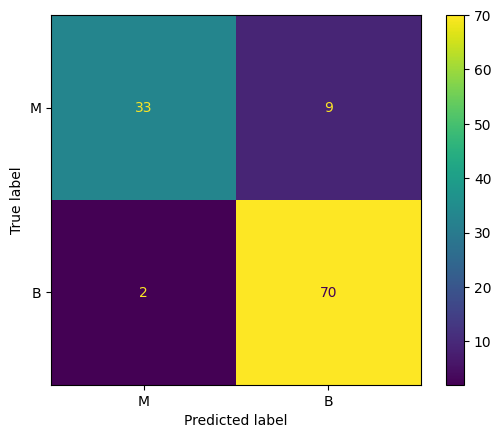

In [37]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()

start_train = perf_counter()
qda.fit(x_train_scaled, y_train)
finish_train = perf_counter()

start_test = perf_counter()
y_pred = qda.predict(x_test_scaled)
finish_test = perf_counter()

train_time = finish_train - start_train
test_time = finish_test - start_test

accuracy = "%.3f" % metrics.accuracy_score(y_test, y_pred)
precision = "%.3f" % metrics.precision_score(y_test, y_pred, pos_label='M')
recall = "%.3f" % metrics.recall_score(y_test, y_pred, pos_label='M')

print(f'Train Time: {train_time} / Predict Time: {test_time}')
print(f'Accuracy: {accuracy} / Precision: {precision} / Recall: {recall}')
joblib.dump(qda, 'saved_objects/reduced_features_qda.pkl')
cm = confusion_matrix(y_test, y_pred, labels=['M', 'B'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
							  display_labels=['M', 'B'])
disp.plot()
# plt.show()
plt.savefig('visuals/confusion_matrix/reduced_features_qda_confusion_matrix.png')

Train Time: 0.11300440004561096 / Predict Time: 0.001566199993249029
Accuracy: 0.956 / Precision: 1.000 / Recall: 0.881


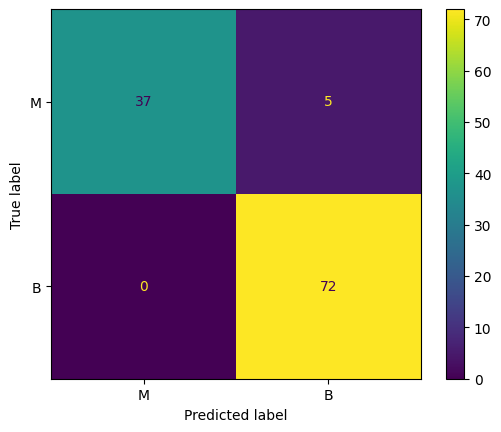

In [38]:
from sklearn.gaussian_process import GaussianProcessClassifier

gp = GaussianProcessClassifier()

start_train = perf_counter()
gp.fit(x_train_scaled, y_train)
finish_train = perf_counter()

start_test = perf_counter()
y_pred = gp.predict(x_test_scaled)
finish_test = perf_counter()

train_time = finish_train - start_train
test_time = finish_test - start_test

accuracy = "%.3f" % metrics.accuracy_score(y_test, y_pred)
precision = "%.3f" % metrics.precision_score(y_test, y_pred, pos_label='M')
recall = "%.3f" % metrics.recall_score(y_test, y_pred, pos_label='M')

print(f'Train Time: {train_time} / Predict Time: {test_time}')
print(f'Accuracy: {accuracy} / Precision: {precision} / Recall: {recall}')
joblib.dump(gp, 'saved_objects/reduced_features_gp.pkl')
cm = confusion_matrix(y_test, y_pred, labels=['M', 'B'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
							  display_labels=['M', 'B'])
disp.plot()
# plt.show()
plt.savefig('visuals/confusion_matrix/reduced_features_gaussian_process_confusion_matrix.png')